In [1]:
import numpy as np
import pandas as pd
import json
from math import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)

In [3]:
with open('config.json') as f:
    config = json.load(f)

data_path = config["bit-finex"]

ts = pd.read_csv(data_path)
ts = ts["close"].values

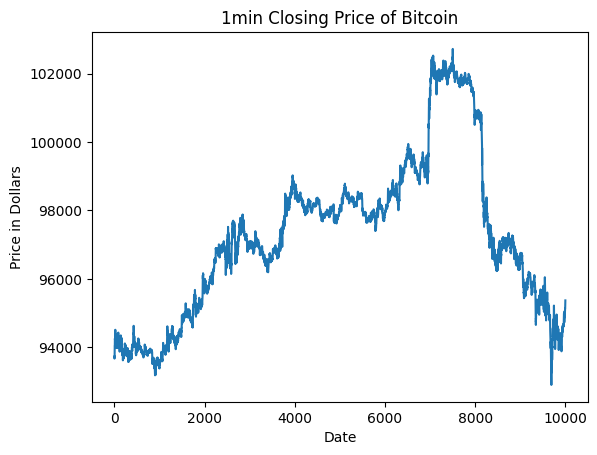

In [4]:
plt.plot(ts)
plt.title('1min Closing Price of Bitcoin')
plt.xlabel('Date')
plt.ylabel('Price in Dollars')
plt.show()

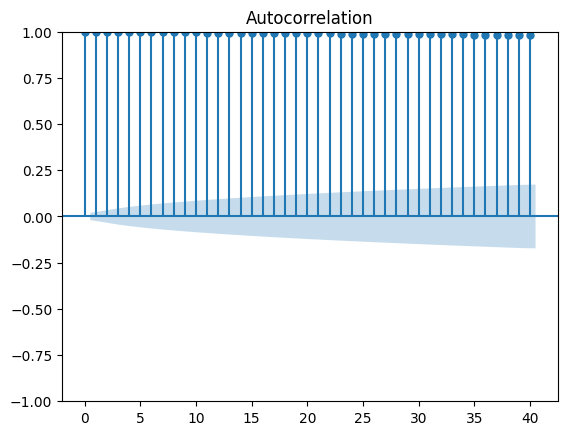

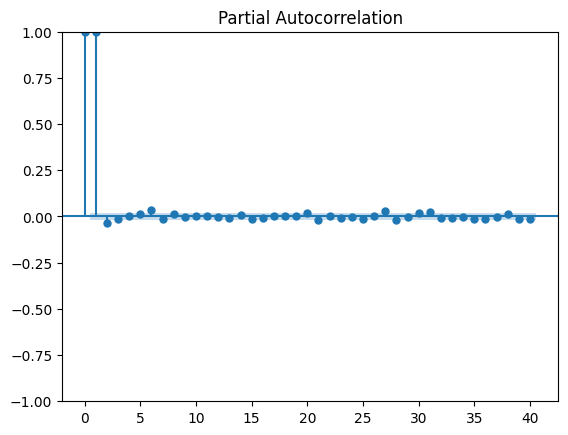

In [5]:
plot_acf(ts)
plt.show()

plot_pacf(ts)
plt.show()

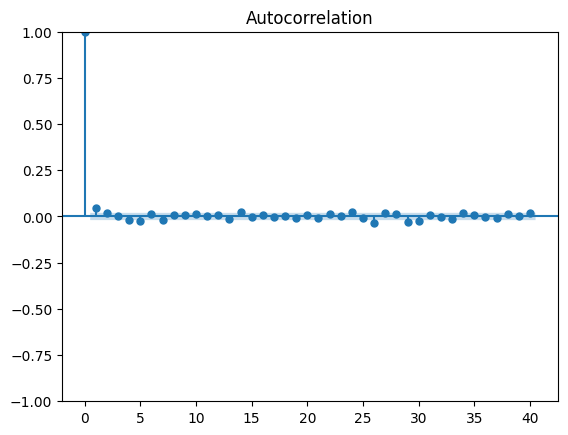

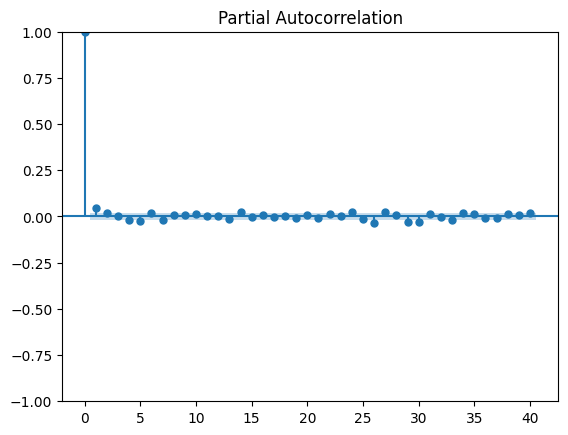

In [6]:
diff = np.diff(ts)

plot_acf(diff)
plt.show()

plot_pacf(diff)
plt.show()

In [16]:
unit_test = adfuller(diff)

#Print results
print('ADF Statistic: %f' % unit_test[0])
print('p-value: %f' % unit_test[1])
print('Critical Values:', unit_test[4])

if unit_test[1] <= 0.05:
    print(f'Reject the null hypothesis. The time-series is stationary.')
else: 
    print(f"Fail to reject the null hypothesis. The time-series is non-stationary")

ADF Statistic: -18.779026
p-value: 0.000000
Critical Values: {'1%': -3.431006132472577, '5%': -2.861829971423364, '10%': -2.566924346651971}
Reject the null hypothesis. The time-series is stationary.


In [8]:
# train-validation-test split for time series
train_size = int(len(ts) * 0.70)
train, test = ts[:train_size], ts[train_size:]

print(len(train))
print(len(test))

7000
3000


## Training

In [9]:
def training_process(train_set):
    '''
    Selects the most optimal model parameters based on AIC or BIC. 

    Input: training set
    Output: optimal p, optimal q, rmse, predictions
    '''

    #These are the values to be returned by this function
    best_p = None
    best_q = None
    lowest_bic = float('inf')

    #Run through each possible p and q in our selected range
    for p in range(0,7):
        for q in range(0,7):
            try:
                model = ARIMA(train_set, order=(p,1,q))
                results = model.fit()
                bic = results.bic
                print(f'ARIMA({p},1,{q}), BIC: {bic}')


                #Update optimal ARMA model based on bic and update its predictions
                if bic < lowest_bic:
                    best_p = p
                    best_q = q
                    lowest_bic = bic
                    print(f"BIC: {lowest_bic} New best p and q: {best_p}, {best_q}")

            except Exception as e:
                print(f'Skipped ARIMA({p},1,{q}) due to: {e}')
            
    return best_p, best_q

best_p, best_q = training_process(train)

ARIMA(0,1,0), BIC: 73439.95106711339
BIC: 73439.95106711339 New best p and q: 0, 0
ARIMA(0,1,1), BIC: 73384.71491862582
BIC: 73384.71491862582 New best p and q: 0, 1
ARIMA(0,1,2), BIC: 73390.4800043477
ARIMA(0,1,3), BIC: 73392.26848760416
ARIMA(0,1,4), BIC: 73395.46156440444
ARIMA(0,1,5), BIC: 73403.44072730985
ARIMA(0,1,6), BIC: 73412.0553092491
ARIMA(1,1,0), BIC: 73382.30677369522
BIC: 73382.30677369522 New best p and q: 1, 0
ARIMA(1,1,1), BIC: 73388.63213659021
ARIMA(1,1,2), BIC: 73397.47502189426
ARIMA(1,1,3), BIC: 73398.53297267885
ARIMA(1,1,4), BIC: 73403.44442285603
ARIMA(1,1,5), BIC: 73411.46704277322
ARIMA(1,1,6), BIC: 73420.12089678664
ARIMA(2,1,0), BIC: 73389.22371399163
ARIMA(2,1,1), BIC: 73397.47718876996
ARIMA(2,1,2), BIC: 73402.58551840902
ARIMA(2,1,3), BIC: 73390.2121088564
ARIMA(2,1,4), BIC: 73412.7097022967
ARIMA(2,1,5), BIC: 73405.41014662532
ARIMA(2,1,6), BIC: 73411.70369853343
ARIMA(3,1,0), BIC: 73394.84320284669
ARIMA(3,1,1), BIC: 73399.96334919578
ARIMA(3,1,2), B

In [10]:
print(f'Optimal ARIMA Model: ARIMA({best_p},1,{best_q})\n')

train_model = ARIMA(train, order=(best_p,1,best_q))
results = train_model.fit()
print(results.summary())

Optimal ARIMA Model: ARIMA(1,1,0)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7000
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -36682.300
Date:                Wed, 15 Jan 2025   AIC                          73368.600
Time:                        17:02:11   BIC                          73382.307
Sample:                             0   HQIC                         73373.323
                               - 7000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0971      0.007     14.277      0.000       0.084       0.110
sigma2      2088.0432     14.381    145.191      0.000    2059.856    2116.230
Ljung-Box (L1) (Q

Train RMSE: 45.701911096519076


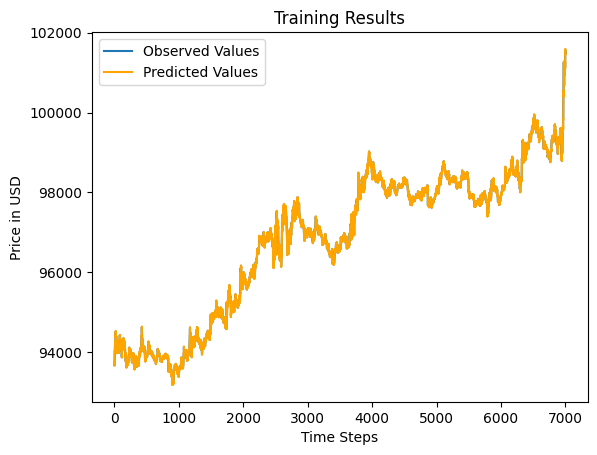

In [11]:
train_predictions = results.fittedvalues[1:] #remove the first value due to differencing in ARIMA

train_mse = mean_squared_error(train[1:], train_predictions)
train_rmse = sqrt(train_mse)
print(f"Train RMSE: {train_rmse}")

plt.plot(train[1:], label='Observed Values')
plt.plot(train_predictions, c='orange', label="Predicted Values")
plt.title("Training Results")
plt.xlabel('Time Steps')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

## Testing

In [12]:
def testing_process(training_set, testing_set, p, q):
    '''
    Makes out-of-sample predictions on the testing set.

    Input: train, validation, and testing set, optimal p and q based on validation testing
    Output: predictions, rmse
    '''

    history = list(training_set)
    predictions = []

    #Prediction
    for i in range(len(testing_set)):
        model = ARIMA(history, order=(p,1,q))
        results = model.fit()
        
        #One-step-ahead forecast
        yhat = results.forecast()
        yhat = yhat[0]

        #Append history with latest observation and update predictions with latest prediction
        obs = testing_set[i]
        history.append(obs)
        predictions.append(yhat)
    
    #Calculate RMSE
    mse = mean_squared_error(testing_set, predictions)
    rmse = sqrt(mse)
            
    return predictions, rmse

test_predictions, test_rmse = testing_process(train, test, best_p, best_q)

Test RMSE: 70.93568170538674


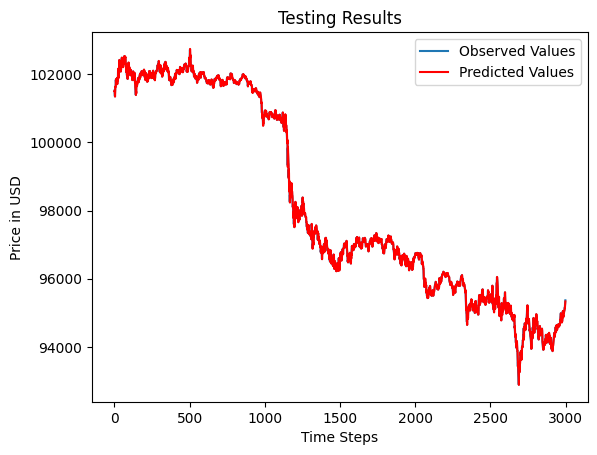

In [13]:
print(f'Test RMSE: {test_rmse}')

plt.plot(test, label='Observed Values')
plt.plot(test_predictions, c='red', label="Predicted Values")
plt.title("Testing Results")
plt.xlabel('Time Steps')
plt.ylabel('Price in USD')
plt.legend()
plt.savefig('graphs/arima-testing-results.png')
plt.show()